In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import pickle

from models_NRI import *
from utils import *

In [ ]:
def compute_confusion(preds, target):
    """compute TN, FP, FN, TP"""
    _, preds = preds.max(-1)
    true_positive = ((preds[target==1]==1).cpu().sum()).item()
    false_negative = ((preds[target==1]==0).cpu().sum()).item()
    true_negative = ((preds[target==0]==0).cpu().sum()).item()
    false_positive = ((preds[target==0]==1).cpu().sum()).item()
    
    return true_negative, false_negative, false_positive, true_positive

# Compute tn, fp, fn, tp

## Spring Simulation data sets

In [ ]:
#path of the gnn encoder file
encoder_file = "logs/nri/wavenetsym__static_10_3_5_2022-/"
encoder = torch.load(encoder_file)
encoder

In [ ]:
#load data
suffix = "_static_10_3_5"
n_atoms = 10

cuda = True


tns = []
fns = []
fps = []
tps = []

off_diag = np.ones([n_atoms, n_atoms]) - np.eye(n_atoms)
rel_rec = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_rec = torch.from_numpy(rel_rec)
rel_send = torch.from_numpy(rel_send)

if cuda:
    rel_rec, rel_send = rel_rec.cuda(), rel_send.cuda()

train_loader, valid_loader, test_loader, loc_max, loc_min, vel_max, vel_min = load_spring_sim(64, 
                                                                                             suffix)
encoder.eval()

for batch_idx, (data, relations) in enumerate(test_loader):
    if cuda:
        data, relations = data.cuda(), relations.cuda()
    relations, relations_masked = relations[:,:,0], relations[:,:,1]
    #data; shape:[n_sims, n_atoms, n_timesteps, n_in]
    #relations; shape:[n_sims, n_edgs]
    logits = encoder(data, rel_rec, rel_send)
    tn,fn,fp,tp = compute_confusion(logits, relations)
    
    tns.append(tn)
    fns.append(fn)
    fps.append(fp)
    tps.append(tp)
    
total_true_negatives = np.sum(tns)
total_false_negatives = np.sum(fns)
total_false_positives = np.sum(fps)
total_true_positives = np.sum(tps)

print("normalized tn: ", total_true_negatives/(total_true_negatives+total_false_positives))
print("normalized fn: ", total_false_negatives/(total_true_positives+total_false_negatives))
print("normalized fp: ", total_false_positives/(total_false_positives+total_true_negatives))
print("normalized tp: ", total_true_positives/(total_false_negatives+total_true_positives))

## Pedestrian data sets

In [ ]:
encoder_file = "logs/nriped/wavenetsym_zara01_split00"
encoder = torch.load(encoder_file)
encoder

In [ ]:
#Load data
suffix = "zara01"
split = "split00"
data_folder = os.path.join("data/pedestrian/", suffix)
data_folder = os.path.join(data_folder, split)


with open(os.path.join(data_folder, "tensors_test.pkl"), 'rb') as f:
    examples_test = pickle.load(f)
with open(os.path.join(data_folder, "labels_test.pkl"), 'rb') as f:
    labels_test = pickle.load(f)

test_indices = np.arange(len(examples_test))

In [ ]:
cuda = True
true_negatives = []
false_negatives = []
false_positives = []
true_positives = []

encoder.eval()

with torch.no_grad():
    for idx in test_indices:
        example = examples_test[idx]
        label = labels_test[idx]
        example = example.unsqueeze(0)
        label = label.unsqueeze(0)
        num_atoms = example.size(1)
        rel_rec, rel_send = create_edgeNode_relation(num_atoms, self_loops=False)
        if cuda:
            example = example.cuda()
            label = label.cuda()
            rel_rec, rel_send = rel_rec.cuda(), rel_send.cuda()
        example = example.float()
        logits = encoder(example, rel_rec, rel_send)
        tn, fn, fp, tp = compute_confusion(logits, label)
        true_negatives.append(tn)
        false_negatives.append(fn)
        false_positives.append(fp)
        true_positives.append(tp)
        
total_true_negatives = np.sum(true_negatives)
total_false_negatives = np.sum(false_negatives)
total_false_positives = np.sum(false_positives)
total_true_positives = np.sum(true_positives)




print("true negatives: ", total_true_negatives)
print("false negatives: ", total_false_negatives)
print("false positives: ", total_false_positives)
print("true positives: ", total_true_positives)


print("normalized tn: ", total_true_negatives/(total_true_negatives+total_false_positives))
print("normalized fn: ", total_false_negatives/(total_true_positives+total_false_negatives))
print("normalized fp: ", total_false_positives/(total_false_positives+total_true_negatives))
print("normalized tp: ", total_true_positives/(total_false_negatives+total_true_positives))

# Confusion Matrices
Plot confusion matrices

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
!mkdir figures/confusionMatrices

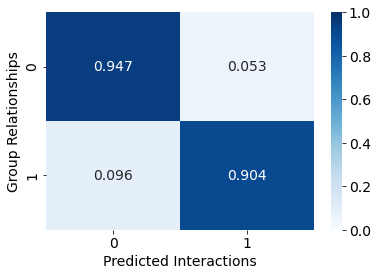

In [7]:
plt.rcParams.update({'font.size': 14})

cf_matrix = np.array([[0.947, 0.053],
                            [0.096, 0.904]])




sns.heatmap(cf_matrix, annot=True, fmt='', cmap="Blues", vmin=0, vmax=1)


plt.xlabel("Predicted Interactions")
plt.ylabel("Group Relationships")

plt.savefig("figures/confusionMatrices/Hotel_yamaguchi.pdf")


plt.show()